<a href="https://colab.research.google.com/github/vishal36-pop/kaggle-csiro-competition/blob/main/notebook(colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()
username = 'vishalreddyk'
token = 'db5da92f0750e29428cbc1a2ed8e2dfb'

In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

csiro_biomass_path = kagglehub.competition_download('csiro-biomass')

print('Data source import complete.')


100%|██████████| 1.02G/1.02G [00:10<00:00, 103MB/s] 

Extracting files...


Data source import complete.


In [48]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset,DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.optim as optim

In [5]:
import os
path = csiro_biomass_path
print(path)
os.listdir(path)

/root/.cache/kagglehub/competitions/csiro-biomass


['train.csv', 'test', 'train', 'sample_submission.csv', 'test.csv']

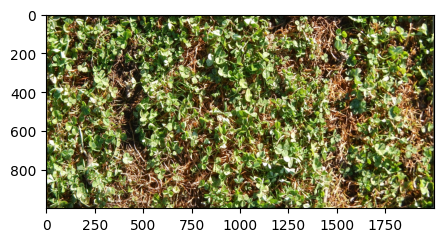

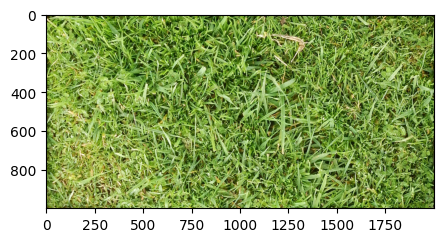

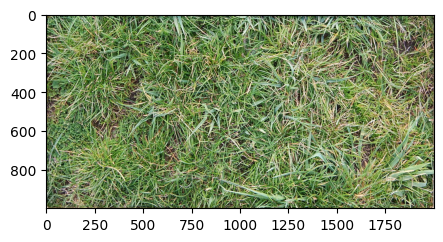

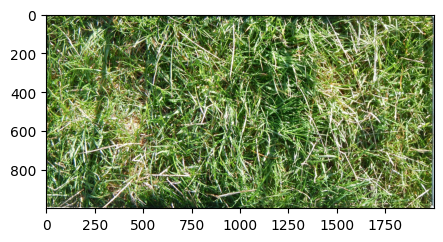

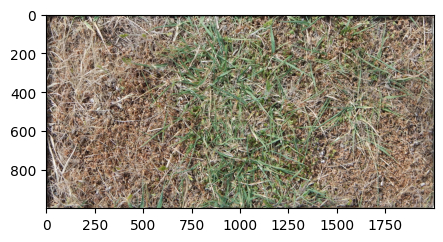

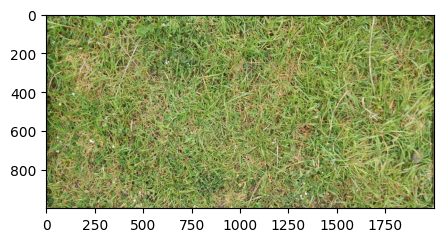

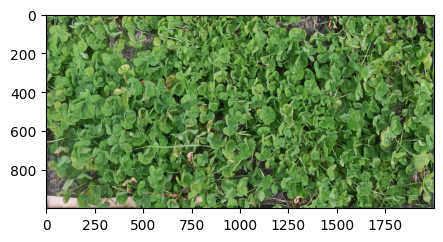

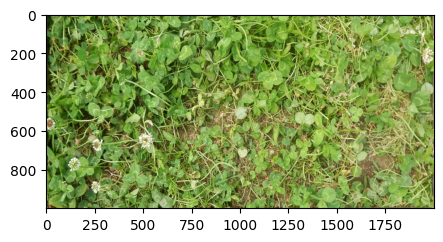

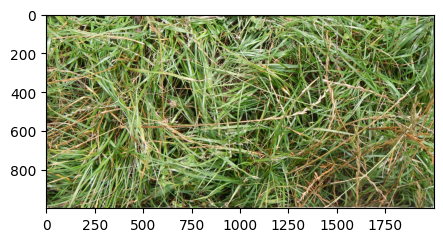

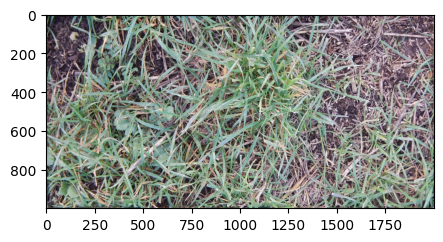

In [6]:
from PIL import Image
#only upto 10 images
count = 0
for file in os.listdir(path+'/train'):
    with Image.open(path+'/train/'+file) as f:
        fig,ax = plt.subplots(figsize=(5,5))
        ax.imshow(f)
        count+=1
    if count == 10 :
        break

In [7]:
import pandas as pd
data = pd.read_csv(path+'/train.csv')
data.head()

sample_id              image_path Sampling_Date State  \
0  ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas   
1    ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas   
2   ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas   
3   ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas   
4         ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas   

           Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target  
0  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000  
1  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984  
2  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751  
3  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735  
4  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750

In [8]:

data['Sampling_Date'] = pd.to_datetime(data['Sampling_Date'], dayfirst=True, errors='coerce')
data['Day'] = data['Sampling_Date'].dt.day
data['Month'] = data['Sampling_Date'].dt.month
data['Year'] = data['Sampling_Date'].dt.year

data[['Sampling_Date', 'Day', 'Month', 'Year']].head()

Sampling_Date  Day  Month    Year
0    2015-04-09  9.0    4.0  2015.0
1    2015-04-09  9.0    4.0  2015.0
2    2015-04-09  9.0    4.0  2015.0
3    2015-04-09  9.0    4.0  2015.0
4    2015-04-09  9.0    4.0  2015.0

In [9]:
data.isna().sum(axis=0).sum()

np.int64(3980)

In [10]:
!pip install scikit-learn --quiet

In [11]:
#drop the smapling date and the sample id 
data.drop(columns=['sample_id','Sampling_Date'],inplace=True)

In [12]:
data.head()

image_path State          Species  Pre_GSHH_NDVI  \
0  train/ID1011485656.jpg   Tas  Ryegrass_Clover           0.62   
1  train/ID1011485656.jpg   Tas  Ryegrass_Clover           0.62   
2  train/ID1011485656.jpg   Tas  Ryegrass_Clover           0.62   
3  train/ID1011485656.jpg   Tas  Ryegrass_Clover           0.62   
4  train/ID1011485656.jpg   Tas  Ryegrass_Clover           0.62   

   Height_Ave_cm   target_name   target  Day  Month    Year  
0         4.6667  Dry_Clover_g   0.0000  9.0    4.0  2015.0  
1         4.6667    Dry_Dead_g  31.9984  9.0    4.0  2015.0  
2         4.6667   Dry_Green_g  16.2751  9.0    4.0  2015.0  
3         4.6667   Dry_Total_g  48.2735  9.0    4.0  2015.0  
4         4.6667         GDM_g  16.2750  9.0    4.0  2015.0

In [13]:
data['State'].unique()

array(['Tas', 'NSW', 'WA', 'Vic'], dtype=object)

In [14]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(data[['Species', 'target_name','State']])

# Convert to dataframe and concatenate
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Species', 'target_name','State']))
data = pd.concat([data.drop(columns=['Species', 'target_name','State']), encoded_df], axis=1)
data

image_path  Pre_GSHH_NDVI  Height_Ave_cm   target  Day  \
0     train/ID1011485656.jpg           0.62         4.6667   0.0000  9.0   
1     train/ID1011485656.jpg           0.62         4.6667  31.9984  9.0   
2     train/ID1011485656.jpg           0.62         4.6667  16.2751  9.0   
3     train/ID1011485656.jpg           0.62         4.6667  48.2735  9.0   
4     train/ID1011485656.jpg           0.62         4.6667  16.2750  9.0   
...                      ...            ...            ...      ...  ...   
1780   train/ID983582017.jpg           0.64         9.0000   0.0000  9.0   
1781   train/ID983582017.jpg           0.64         9.0000   0.0000  9.0   
1782   train/ID983582017.jpg           0.64         9.0000  40.9400  9.0   
1783   train/ID983582017.jpg           0.64         9.0000  40.9400  9.0   
1784   train/ID983582017.jpg           0.64         9.0000  40.9400  9.0   

      Month    Year  Species_Clover  Species_Fescue  Species_Fescue_CrumbWeed  \
0       4.0  2015.0             0.0             0.0                       0.0   
1       4.0  2015.0             0.0             0.0                       0.0   
2       4.0  2015.0             0.0             0.0                       0.0   
3       4.0  2015.0             0.0             0.0                       0.0   
4       4.0  2015.0             0.0             0.0                       0.0   
...     ...     ...             ...             ...                       ...   
1780    1.0  2015.0             0.0             0.0                       0.0   
1781    1.0  2015.0             0.0             0.0                       0.0   
1782    1.0  2015.0             0.0             0.0                       0.0   
1783    1.0  2015.0             0.0             0.0                       0.0   
1784    1.0  2015.0             0.0             0.0                       0.0   

      ...  Species_WhiteClover  target_name_Dry_Clover_g  \
0     ...                  0.0                       1.0   
1     ...                  0.0                       0.0   
2     ...                  0.0                       0.0   
3     ...                  0.0                       0.0   
4     ...                  0.0                       0.0   
...   ...                  ...                       ...   
1780  ...                  0.0                       1.0   
1781  ...                  0.0                       0.0   
1782  ...                  0.0                       0.0   
1783  ...                  0.0                       0.0   
1784  ...                  0.0                       0.0   

      target_name_Dry_Dead_g  target_name_Dry_Green_g  \
0                        0.0                      0.0   
1                        1.0                      0.0   
2                        0.0                      1.0   
3                        0.0                      0.0   
4                        0.0                      0.0   
...                      ...                      ...   
1780                     0.0                      0.0   
1781                     1.0                      0.0   
1782                     0.0                      1.0   
1783                     0.0                      0.0   
1784                     0.0                      0.0   

      target_name_Dry_Total_g  target_name_GDM_g  State_NSW  State_Tas  \
0                         0.0                0.0        0.0        1.0   
1                         0.0                0.0        0.0        1.0   
2                         0.0                0.0        0.0        1.0   
3                         1.0                0.0        0.0        1.0   
4                         0.0                1.0        0.0        1.0   
...                       ...                ...        ...        ...   
1780                      0.0                0.0        0.0        0.0   
1781                      0.0                0.0        0.0        0.0   
1782                      0.0                0.0        0.0 

In [15]:
X = data.drop(columns=['target'])
y = data['target']

In [16]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean= True,with_std=True)
X_standard = sc.fit_transform(X.iloc[:,1:])
print(X_standard.shape, X.shape)
data_without_images = pd.DataFrame(X_standard, columns=X.columns[1:])
X = pd.concat((X['image_path'],data_without_images),axis=1)

(1785, 29) (1785, 30)


In [17]:
data_without_images.head()

Pre_GSHH_NDVI  Height_Ave_cm       Day     Month  Year  Species_Clover  \
0      -0.246319      -0.285204  0.293732 -0.393733   0.0       -0.360204   
1      -0.246319      -0.285204  0.293732 -0.393733   0.0       -0.360204   
2      -0.246319      -0.285204  0.293732 -0.393733   0.0       -0.360204   
3      -0.246319      -0.285204  0.293732 -0.393733   0.0       -0.360204   
4      -0.246319      -0.285204  0.293732 -0.393733   0.0       -0.360204   

   Species_Fescue  Species_Fescue_CrumbWeed  Species_Lucerne  Species_Mixed  \
0        -0.29173                  -0.16976        -0.256265      -0.075059   
1        -0.29173                  -0.16976        -0.256265      -0.075059   
2        -0.29173                  -0.16976        -0.256265      -0.075059   
3        -0.29173                  -0.16976        -0.256265      -0.075059   
4        -0.29173                  -0.16976        -0.256265      -0.075059   

   ...  Species_WhiteClover  target_name_Dry_Clover_g  target_name_Dry_Dead_g  \
0  ...             -0.16976                       2.0                    -0.5   
1  ...             -0.16976                      -0.5                     2.0   
2  ...             -0.16976                      -0.5                    -0.5   
3  ...             -0.16976                      -0.5                    -0.5   
4  ...             -0.16976                      -0.5                    -0.5   

   target_name_Dry_Green_g  target_name_Dry_Total_g  target_name_GDM_g  \
0                     -0.5                     -0.5               -0.5   
1                     -0.5                     -0.5               -0.5   
2                      2.0                     -0.5               -0.5   
3                     -0.5                      2.0               -0.5   
4                     -0.5                     -0.5                2.0   

   State_NSW  State_Tas  State_Vic  State_WA  
0  -0.515711   1.259745  -0.676123 -0.313786  
1  -0.515711   1.259745  -0.676123 -0.313786  
2  -0.515711   1.259745  -0.676123 -0.313786  
3  -0.515711   1.259745  -0.676123 -0.313786  
4  -0.515711   1.259745  -0.676123 -0.313786  

[5 rows x 29 columns]

In [18]:
X.head()

image_path  Pre_GSHH_NDVI  Height_Ave_cm       Day     Month  \
0  train/ID1011485656.jpg      -0.246319      -0.285204  0.293732 -0.393733   
1  train/ID1011485656.jpg      -0.246319      -0.285204  0.293732 -0.393733   
2  train/ID1011485656.jpg      -0.246319      -0.285204  0.293732 -0.393733   
3  train/ID1011485656.jpg      -0.246319      -0.285204  0.293732 -0.393733   
4  train/ID1011485656.jpg      -0.246319      -0.285204  0.293732 -0.393733   

   Year  Species_Clover  Species_Fescue  Species_Fescue_CrumbWeed  \
0   0.0       -0.360204        -0.29173                  -0.16976   
1   0.0       -0.360204        -0.29173                  -0.16976   
2   0.0       -0.360204        -0.29173                  -0.16976   
3   0.0       -0.360204        -0.29173                  -0.16976   
4   0.0       -0.360204        -0.29173                  -0.16976   

   Species_Lucerne  ...  Species_WhiteClover  target_name_Dry_Clover_g  \
0        -0.256265  ...             -0.16976                       2.0   
1        -0.256265  ...             -0.16976                      -0.5   
2        -0.256265  ...             -0.16976                      -0.5   
3        -0.256265  ...             -0.16976                      -0.5   
4        -0.256265  ...             -0.16976                      -0.5   

   target_name_Dry_Dead_g  target_name_Dry_Green_g  target_name_Dry_Total_g  \
0                    -0.5                     -0.5                     -0.5   
1                     2.0                     -0.5                     -0.5   
2                    -0.5                      2.0                     -0.5   
3                    -0.5                     -0.5                      2.0   
4                    -0.5                     -0.5                     -0.5   

   target_name_GDM_g  State_NSW  State_Tas  State_Vic  State_WA  
0               -0.5  -0.515711   1.259745  -0.676123 -0.313786  
1               -0.5  -0.515711   1.259745  -0.676123 -0.313786  
2               -0.5  -0.515711   1.259745  -0.676123 -0.313786  
3               -0.5  -0.515711   1.259745  -0.676123 -0.313786  
4                2.0  -0.515711   1.259745  -0.676123 -0.313786  

[5 rows x 30 columns]

In [19]:
from torchvision import transforms
img_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.ColorJitter(0.2, 0.2, 0.15, 0.05),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomAdjustSharpness(1.3, p=0.15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

torch.Size([3, 224, 224])


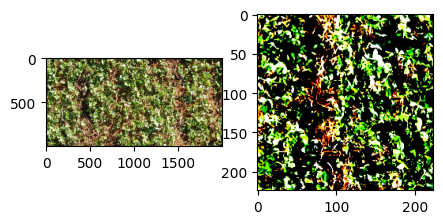

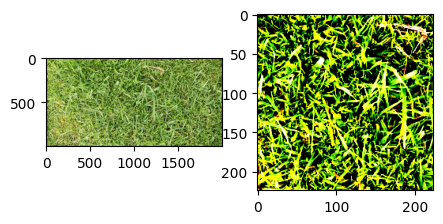

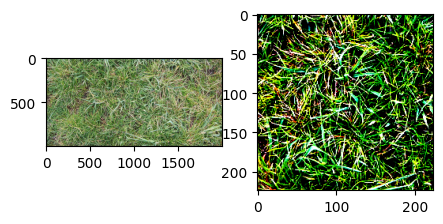

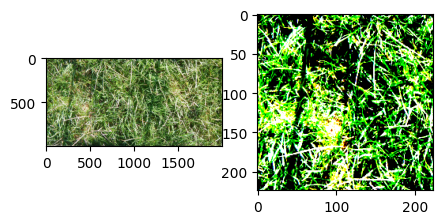

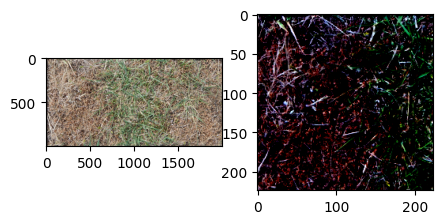

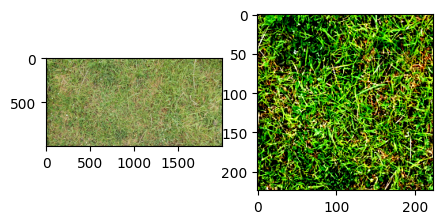

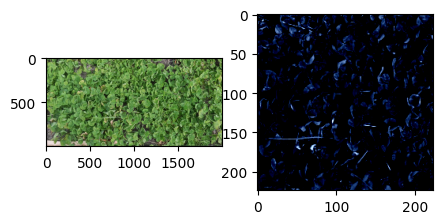

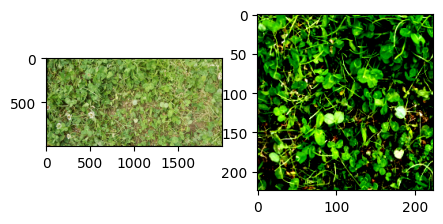

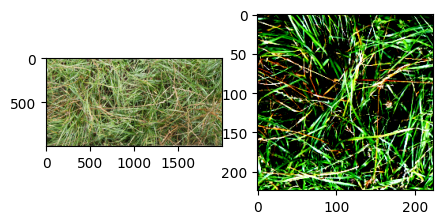

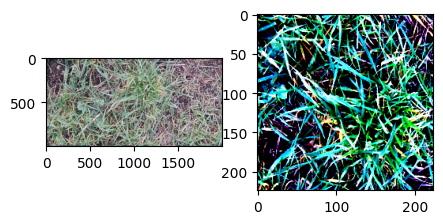

In [46]:
count = 0
for file in os.listdir(path+'/train'):
    with Image.open(path+'/train/'+file) as f:
        fig,ax = plt.subplots(1,2,figsize=(5,5))
        ax[0].imshow(f)
        ax[1].imshow(img_transforms(f).permute(1,2,0))
        count+=1
    if count == 10:
        print(img_transforms(f).shape)
        break

In [20]:
class Csiro(Dataset):
    '''Data set for the training purpose'''
    def __init__(self,data_transforms = None):
        self.x = torch.FloatTensor(X.iloc[:,1:].to_numpy())
        self.image_list = X.iloc[:,0].to_numpy()
        self.y = torch.FloatTensor(y)
        self.data_transforms = data_transforms
    def __len__(self):
        return self.x.size()[0]
    def __getitem__(self,index):
        imgpth,x,y = path+'/'+self.image_list[index],self.x[index],self.y[index]
        if self.data_transforms:
            image = Image.open(imgpth)
            image = self.data_transforms(image)
        return image,x,y

In [21]:
traindataset = Csiro(data_transforms=img_transforms)


In [22]:
traindataset.image_list

array(['train/ID1011485656.jpg', 'train/ID1011485656.jpg',
       'train/ID1011485656.jpg', ..., 'train/ID983582017.jpg',
       'train/ID983582017.jpg', 'train/ID983582017.jpg'], dtype=object)

In [23]:
train_data = DataLoader(traindataset,batch_size=128,shuffle= True)

In [24]:
#check an item 
next(iter(train_data))

[tensor([[[[ 0.3652,  0.1426, -0.1486,  ..., -0.6281, -0.9705, -0.9877],
           [-0.6281, -0.3369, -0.4054,  ..., -0.8849, -1.0733, -1.1589],
           [-0.3027, -0.3027, -0.1314,  ..., -1.1247, -1.0562, -0.9534],
           ...,
           [-1.2959, -0.7308, -1.4500,  ...,  0.1083, -0.0801, -0.1143],
           [-0.6794, -1.0048, -1.5014,  ...,  0.1939, -0.1657, -0.3369],
           [-0.3198, -1.2959, -1.3987,  ...,  0.3138, -0.1486, -0.1828]],
 
          [[ 0.2752,  0.1702, -0.0749,  ..., -0.7052, -1.0728, -1.1253],
           [-0.6001, -0.0574, -0.0399,  ..., -0.9853, -1.1779, -1.1954],
           [-0.1975, -0.2850,  0.0126,  ..., -1.1779, -1.1429, -0.8978],
           ...,
           [-1.5280, -0.9153, -1.5980,  ...,  0.0826, -0.3901, -0.5126],
           [-0.8978, -1.1078, -1.6331,  ...,  0.0651, -0.4601, -0.7402],
           [-0.4426, -1.3179, -1.4230,  ...,  0.1352, -0.4251, -0.5476]],
 
          [[ 0.1128, -0.1835, -0.4973,  ..., -0.5670, -1.0376, -1.1770],
           [-

In [37]:
from torchvision.models import resnet18
imgmodel = resnet18(weights= models.ResNet18_Weights.IMAGENET1K_V1)
imgmodel.fc = nn.Identity()

In [38]:
class Tabularblock(nn.Module):
    def __init__(self,inf,outf,drop=0.1):
        super().__init__()
        self.block = nn.Sequential(
                nn.Linear(inf,outf),
                nn.BatchNorm1d(outf),
                nn.ReLU(),
                nn.Dropout(drop),
        )
    def forward(self,x):
        return self.block(x)


In [39]:
class TabularNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            Tabularblock(29, 14),

            Tabularblock(14, 14),

            Tabularblock(14, 10),

            Tabularblock(10, 10),

            #final layers
            nn.Linear(10, 6),
            nn.BatchNorm1d(6),
            nn.ReLU(),

            nn.Linear(6, 8)  # final tabular embedding
        )

    def forward(self, x):
        return self.net(x)


In [42]:
class CsiroNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.tabularnet = TabularNet()
        self.imgmodel = imgmodel
        self.layers = nn.Sequential(
            Tabularblock(520,256),
            nn.Linear(256,1)
        )
    def forward(self,img,x):
        imgfor = self.imgmodel(img)
        tabfor = self.tabularnet(x)
        x_flatten = torch.concatenate((imgfor,tabfor),dim =1)
        return self.layers(x_flatten)
        

In [43]:
model = CsiroNet()

In [47]:
model(torch.rand(4,3,244,233),torch.rand(4,29))

tensor([[ 0.7947],
        [-0.1045],
        [-0.9908],
        [-0.3186]], grad_fn=<AddmmBackward0>)

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [53]:
def train_model(model:CsiroNet,lr=0.001,weightdecay=0.0001,momentum = 0.90,epochs = 90,device = device):
    optimizer = optim.Adam(model.parameters(),lr=lr,weightdecay=weightdecay,momentum = momentum)
    loss_fn = torch.nn.SmoothL1Loss(beta=1.0)
    train_loss =  []
    #move model to device
    model.to(device)
    for epoch in range(1,epochs+1) :
        trainlossepoch= 0
        for img,x,y in train_data:
            #move img,x,y to device
            img,x,y = img.to(device),x.to(device),y.to(device)
            #optimizer to zero
            optimizer.zerograd()
            #forward
            y_pred = model(img,x)
            #loss
            loss = loss_fn(y_pred,y)
            #back
            loss.backward()
            #optimizer step
            optimizer.step()
            #add loss the train loss in this epoch
            trainloss += loss.cpu().item()
        if epoch%10 == 0:
            print(f'epoch{epoch} | loss{trainlossepoch:.4f}')
    return train_loss


    

In [50]:
model = CsiroNet()
model.state_dict().keys()

odict_keys(['tabularnet.net.0.block.0.weight', 'tabularnet.net.0.block.0.bias', 'tabularnet.net.0.block.1.weight', 'tabularnet.net.0.block.1.bias', 'tabularnet.net.0.block.1.running_mean', 'tabularnet.net.0.block.1.running_var', 'tabularnet.net.0.block.1.num_batches_tracked', 'tabularnet.net.1.block.0.weight', 'tabularnet.net.1.block.0.bias', 'tabularnet.net.1.block.1.weight', 'tabularnet.net.1.block.1.bias', 'tabularnet.net.1.block.1.running_mean', 'tabularnet.net.1.block.1.running_var', 'tabularnet.net.1.block.1.num_batches_tracked', 'tabularnet.net.2.block.0.weight', 'tabularnet.net.2.block.0.bias', 'tabularnet.net.2.block.1.weight', 'tabularnet.net.2.block.1.bias', 'tabularnet.net.2.block.1.running_mean', 'tabularnet.net.2.block.1.running_var', 'tabularnet.net.2.block.1.num_batches_tracked', 'tabularnet.net.3.block.0.weight', 'tabularnet.net.3.block.0.bias', 'tabularnet.net.3.block.1.weight', 'tabularnet.net.3.block.1.bias', 'tabularnet.net.3.block.1.running_mean', 'tabularnet.net.